# SC1015 Mini Project

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime

from matplotlib import pyplot as plt
from IPython.display import clear_output

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam

from livelossplot import PlotLossesKeras

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

2024-04-24 21:46:37.989285: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 21:46:37.999857: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 21:46:38.103401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 21:46:39.539633: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the CSV file
dataset_df = pd.read_csv('dataset/dataset.csv')
dataset_df.head()

,file_id,file_hash,process_id,malicious,api,tid,index
0,2177,3d678bb01678e11b8e01388356891a3f6016824cabc67a...,0,1,RtlSetCurrentTransaction,1780,0
1,2177,3d678bb01678e11b8e01388356891a3f6016824cabc67a...,0,1,NtOpenKeyEx,1780,1
2,2177,3d678bb01678e11b8e01388356891a3f6016824cabc67a...,0,1,RtlSetCurrentTransaction,1780,2
3,2177,3d678bb01678e11b8e01388356891a3f6016824cabc67a...,0,1,NtOpenKeyEx,1780,3
4,2177,3d678bb01678e11b8e01388356891a3f6016824cabc67a...,0,1,RtlSetCurrentTransaction,1780,4


In [3]:
# Copy df
df = dataset_df.copy()
print("* before truncation *")
print(f"{df.shape = }")
print(df.drop_duplicates(subset='file_hash').groupby('malicious')['file_hash'].count())

# Get maximum of 450 file hashes from both malicious == 1/0
# Both quantities should be relatively close to each other
malicious_0 = df[df['malicious'] == 0].drop_duplicates(subset='file_hash').sample(n=450, random_state=42)
malicious_1 = df[df['malicious'] == 1].drop_duplicates(subset='file_hash').sample(n=450, random_state=42)

# Concat the two and extract to dataframe
result = pd.concat([malicious_1, malicious_0])["file_hash"].to_list()
df = df[df["file_hash"].isin(result)]
print()
print("* after truncation *")
print(df.drop_duplicates(subset='file_hash').groupby('malicious')['file_hash'].count())
print(f"{df.shape = }")

* before truncation *
df.shape = (5439983, 7)
malicious
0     472
1    3610
Name: file_hash, dtype: int64

* after truncation *
malicious
0    450
1    450
Name: file_hash, dtype: int64
df.shape = (1283578, 7)


## Cleaning the dataset

In [4]:
# Create a tokenizer to convert the api column into numerical indices
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['api'])

# Convert the api column into numerical indices
X_api = tokenizer.texts_to_sequences(df['api'])

# Pad the sequences to have the same length
max_length = 10  # adjust this value based on your data
X_api = pad_sequences(X_api, maxlen=max_length)

# Convert the tid and index columns into numerical values
X_tid = df[['tid']].values
X_process_id = df[['process_id']].values
X_index = df[['index']].values

# Concatenate the numerical values and the api indices
X = np.concatenate((X_api, X_tid, X_process_id, X_index), axis=1)

# Encode the label column
le = LabelEncoder()
y = le.fit_transform(df['malicious'])

## Prepare training and test datasets

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1).astype('float32')

# Convert the labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Assuming the number of classes is extracted from y_train
num_classes = y_train.shape[1]

# Update the model architecture
model = Sequential()
model.add(Input((X_train.shape[1], 1)))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.1))
model.add(LSTM(units=64))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training the model

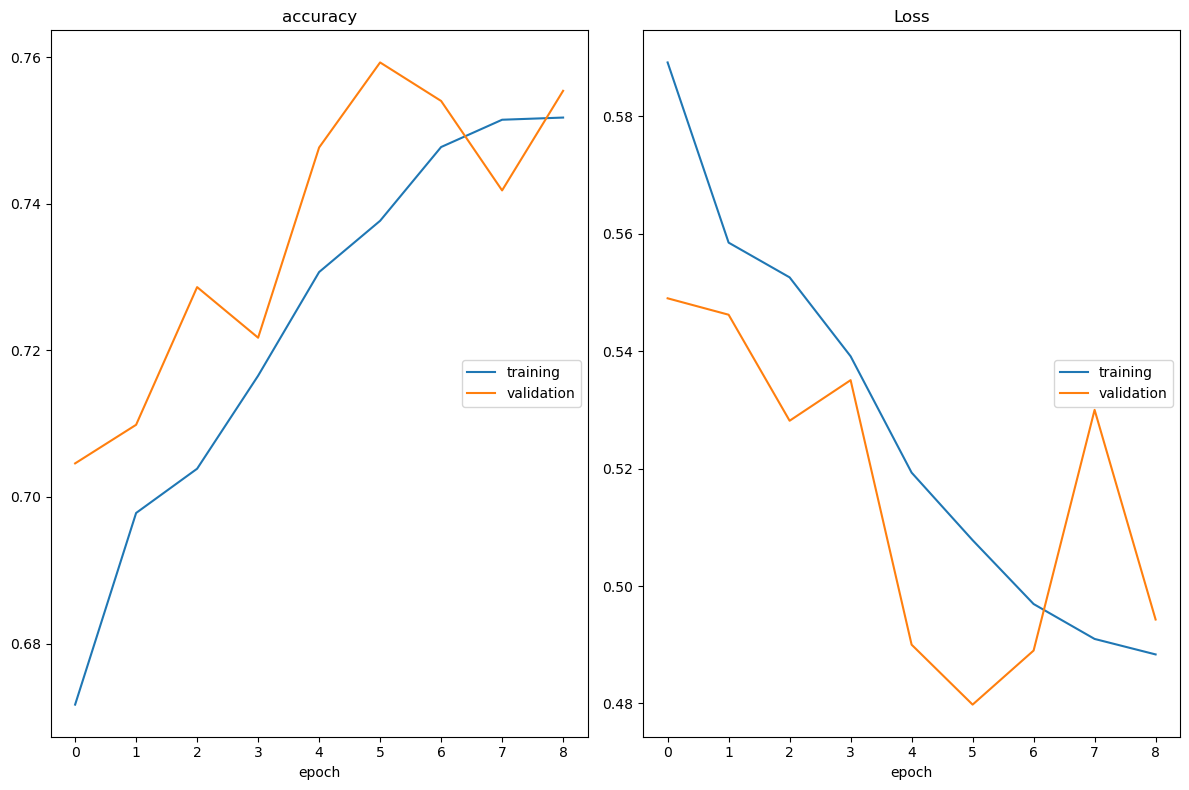

accuracy
	training         	 (min:    0.672, max:    0.752, cur:    0.752)
	validation       	 (min:    0.705, max:    0.759, cur:    0.755)
Loss
	training         	 (min:    0.488, max:    0.589, cur:    0.488)
	validation       	 (min:    0.480, max:    0.549, cur:    0.494)

Epoch 9: val_loss did not improve from 0.47980
16045/16045 ━━━━━━━━━━━━━━━━━━━━ 339s 21ms/step - accuracy: 0.7503 - loss: 0.4913 - val_accuracy: 0.7554 - val_loss: 0.4943


In [6]:
# Callbacks for training
checkpoint_path = 'model/checkpoint.weights.h5'
mckpt = ModelCheckpoint(checkpoint_path,
                        monitor='val_loss', mode='auto', verbose=1,
    					save_best_only=True, save_weights_only=True, save_freq='epoch')
rlstp = EarlyStopping(monitor='val_loss', patience=3)
plot_losses = PlotLossesKeras()

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, callbacks=[plot_losses, mckpt, rlstp], validation_data=(X_test, y_test), verbose=1)

## Loading the best model

In [7]:
# Load the best model
model.load_weights(checkpoint_path)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.3f}')

8023/8023 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - accuracy: 0.7601 - loss: 0.4787
Test accuracy: 0.759


In [8]:
# Predict labels for test data
y_pred = model.predict(X_test)

# Convert predictions to labels (e.g., thresholding)
y_pred_labels = (y_pred > 0.5).astype(int)

# Calculate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_labels, average='macro')
print(f'Test F1 score: {f1:.3f}')

8023/8023 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step
Test F1 score: 0.756


## Conclusion

Based off the accuracy we achieved with our models, it seems that while the accuracy is relatively high and the loss is relatively low, the training could be done over a larger dataset to achieve higher accuracy. However as a proof-of-concept, the results are very promising.